In [1]:
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import data_tools

In [2]:
!pwd

/home/jovyan/ghw2019_planetpieces/contributors/jakidxav


In [2]:
#locate the files, and only get the '_refl.tif' files
data_dir = '/home/jovyan/ghw2019_planetpieces/data/'

data_list = []

filenames = os.listdir(data_dir)

for filename in filenames:
    if filename.endswith('Analytic_refl.tif'):
        data_list.append(filename)

In [3]:
#print out the first five files
data_list[:5]

['703947_1060718_2017-08-22_1035_BGRN_Analytic_refl.tif',
 '794418_1060719_2017-09-28_0f35_BGRN_Analytic_refl.tif',
 '2574848_1060718_2019-08-04_0f4e_BGRN_Analytic_refl.tif',
 '2574618_1060618_2019-08-04_0f3d_BGRN_Analytic_refl.tif',
 '2548533_1060719_2019-07-25_0f15_BGRN_Analytic_refl.tif']

In [5]:
print(len(data_list))

82


In [6]:
#now let's open up each file, and get the green channel
#data shape should be (1, 8000, 8000), create a mask of the same shape
images = []
labels = []

for i, filename in enumerate(data_list[:20]):
    #open the raster data
    data = data_tools.read_raster(data_dir+filename, band=None)[0]
    
    #get the green channel
    img = data[1]
    
    #create mask from threshold value
    mask = np.zeros(np.shape(img))
    
    mask[img > 2500] = 1
    
    #append the data and labels to list
    images.append(img)
    labels.append(mask)
    
    print('Done processing file {}/20'.format(i+1))

Done processing file 1/20
Done processing file 2/20
Done processing file 3/20
Done processing file 4/20
Done processing file 5/20
Done processing file 6/20
Done processing file 7/20
Done processing file 8/20
Done processing file 9/20
Done processing file 10/20
Done processing file 11/20
Done processing file 12/20
Done processing file 13/20
Done processing file 14/20
Done processing file 15/20
Done processing file 16/20
Done processing file 17/20
Done processing file 18/20
Done processing file 19/20
Done processing file 20/20


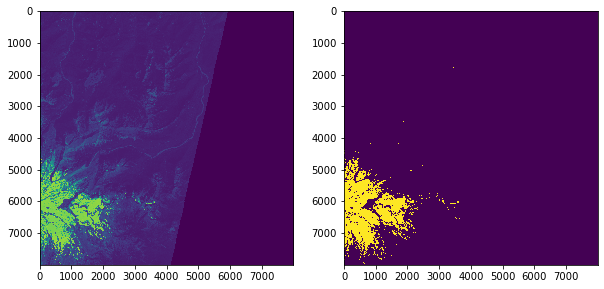

In [8]:
fix, ax = plt.subplots(1, 2, figsize=(10, 10))

ax[0].imshow(images[1])
ax[1].imshow(labels[1])

plt.show()

In [11]:
#first, we need to split the data into training, validation, and test sets
traindata, trainlabels = images[:10], labels[:10]
valdata, vallabels = images[10:15], labels[10:15]
testdata, testlabels = images[15:], labels[15:]

In [14]:
#save the data so that we don't have to redo that processing step
# np.save('traindata.npy', np.asarray(traindata))
# np.save('trainlabels.npy', np.asarray(trainlabels))

# np.save('valdata.npy', np.asarray(valdata))
# np.save('vallabels.npy', np.asarray(vallabels))

# np.save('testdata.npy', np.asarray(testdata))
# np.save('testlabels.npy', np.asarray(testlabels))

print('The data is saved to numpy arrays.')

The data is saved to numpy arrays.


In [ ]:
#load the data if the kernel dies or we need to restart the notebook
traindata = np.load('./traindata.npy')
trainlabels = np.load('./trainlabels.npy')

valdata = np.load('./valdata.npy')
vallabels = np.load('./vallabels.npy')

testdata = np.load('./testdata.npy')
testlabels = np.load('./testlabels.npy')

# Transfer Learning in Tensorflow 2.0

Now that we have our data, we need to train our network. However, building and training a model from scratch is time and compute intensive. There are already many neural network architectures that have proven to do well that we can use. Here, I am going to load in a ResNet50 architecture  in Tensorflow and use the ImageNet weights. Then I can retrain the output layer to predict on my satellite data.

Thank you to to the [Tensorflow Docs](https://www.tensorflow.org/tutorials/images/transfer_learning) and [this](https://lambdalabs.com/blog/tensorflow-2-0-tutorial-02-transfer-learning/) blog post which helped me get started with transfer learning in Tensorflow.

In [6]:
#import the architecture and weights here
backbone = tf.keras.applications.MobileNetV2(weights="imagenet", include_top=False, input_shape=(8000, 8000, 1))

#then freeze those weights for training
#we don't want to change these weights, but only the weights from the output layer
backbone.trainable = False

/home/jovyan/conda-envs/planetpieces/lib/python3.7/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9412608/9406464 [==============================] - 0s 0us/step


In [7]:
#let's inspect the architecture
backbone.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8000, 8000,  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 8001, 8001, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 4000, 4000, 3 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 4000, 4000, 3 128         Conv1[0][0]                      
_______________________________________________________________________________

In [ ]:
#now let's replace the classifier which will predict on two classes
model = tf.keras.Sequential([
  backbone,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(2, activation='sigmoid')
])

In [9]:
epochs = 1

#https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam
optimizer = tf.keras.optimizers.Adam()
loss = 'binary_crossentropy'

#compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

NameError: name 'traindata' is not defined

In [ ]:
#verbose=1 gives a progress bar during training
history = backbone.fit(traindata, epochs=epochs, validation_data=valdata, verbose=1)

In [ ]:
#now let's plot the accuracy and loss across epochs
#helpful link: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

#plot accuracy for 
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])

# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')

# plt.show()

In [ ]:
#plot loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])

# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')

# plt.show()